In [7]:
import pandas as pd 

In [21]:
df = pd.read_csv('modelselection.csv')
df

,dataModel,modelName,trainingTime,precision,recall,f1Score,dataFrameNo
0,countVectorizer+iDF,svm,18.710,0.884,0.856,0.869,df1
1,countVectorizer+iDF,lr,2.179,0.896,0.802,0.846,df2
2,countVectorizer+iDF,nb,1.873,0.853,0.826,0.839,df3
3,countVectorizer+iDF+chisquare,svm,14.566,0.871,0.865,0.868,df4
4,countVectorizer+iDF+chisquare,lr,2.089,0.880,0.861,0.871,df5
5,countVectorizer+iDF+chisquare,nb,0.550,0.836,0.916,0.875,df6
6,unCleanData+countVectorizer+iDF,svm,11.939,0.916,0.872,0.894,df7
7,unCleanData+countVectorizer+iDF,lr,1.413,0.909,0.818,0.861,df8
8,unCleanData+countVectorizer+iDF,nb,0.488,0.880,0.872,0.876,df9
9,ngram+hashingtf+iDF,svm,10.762,0.556,0.427,0.483,df10


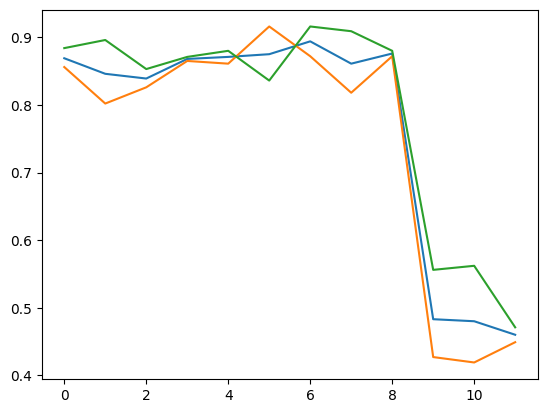

In [22]:
# plot multiple columns such as population and year from dataframe
import matplotlib.pyplot as plt 
# df.plot(x="dataFrameNo", y=["f1Score"],kind="line", figsize=(10, 10))
# df.plot(x="dataFrameNo", y=["recall"],kind="line", figsize=(10, 10))
plt.plot(df[["f1Score"]])
plt.plot(df[["recall"]])
plt.plot(df[["precision"]])
    

<AxesSubplot: xlabel='dataFrameNo'>

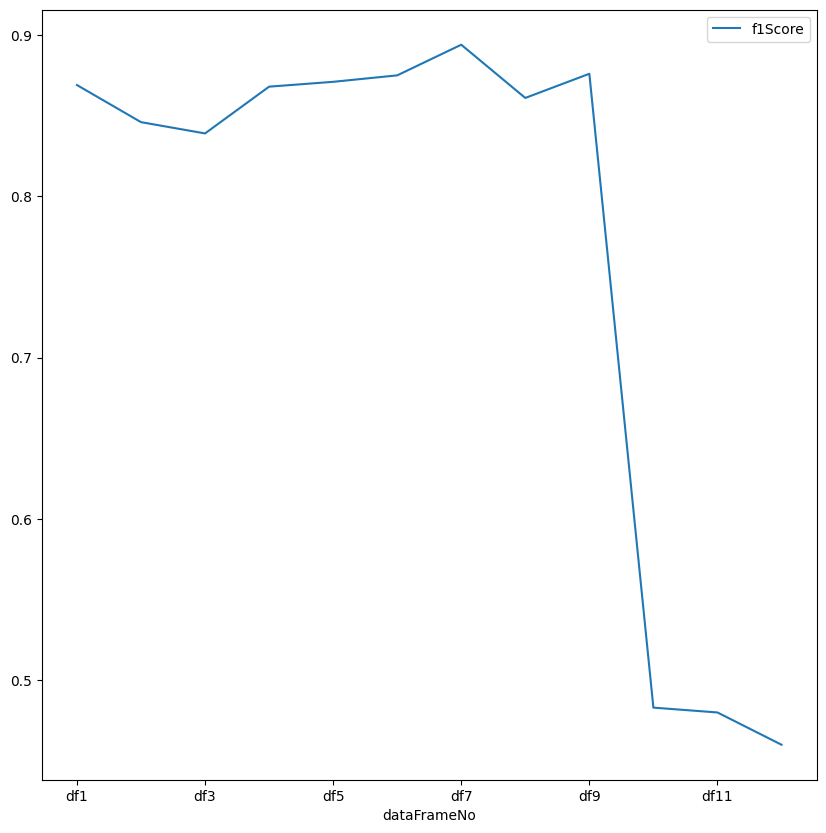

In [23]:
df.plot(x="dataFrameNo", y=["f1Score"],kind="line", figsize=(10, 10))


In [24]:
df.max()

dataModel       unCleanData+countVectorizer+iDF
modelName                                   svm
trainingTime                              18.71
precision                                 0.916
recall                                    0.916
f1Score                                   0.894
dataFrameNo                                 df9
dtype: object

<AxesSubplot: >

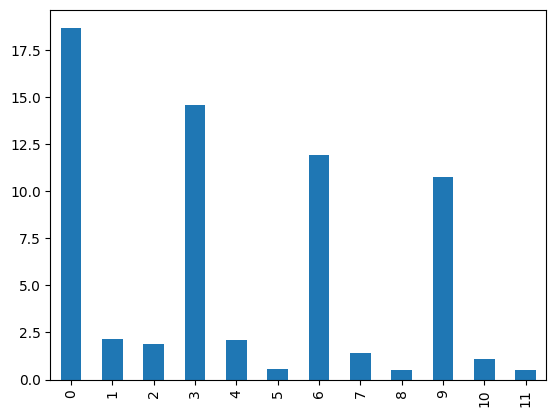

In [35]:
colours = {"unCleanData+countVectorizer+iDF": "#44bd32", "countVectorizer+iDF": "#44bd32", "ngram+hashingtf+iDF":"#273c75"}
df["trainingTime"].plot(kind="bar")

<AxesSubplot: xlabel='trainingTime', ylabel='modelName'>

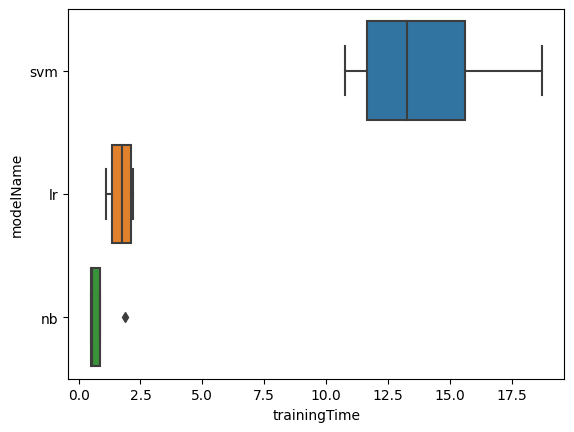

In [37]:
import seaborn as sns


sns.boxplot( x=df["trainingTime"], y=df["modelName"] )

<AxesSubplot: xlabel='trainingTime', ylabel='dataModel'>

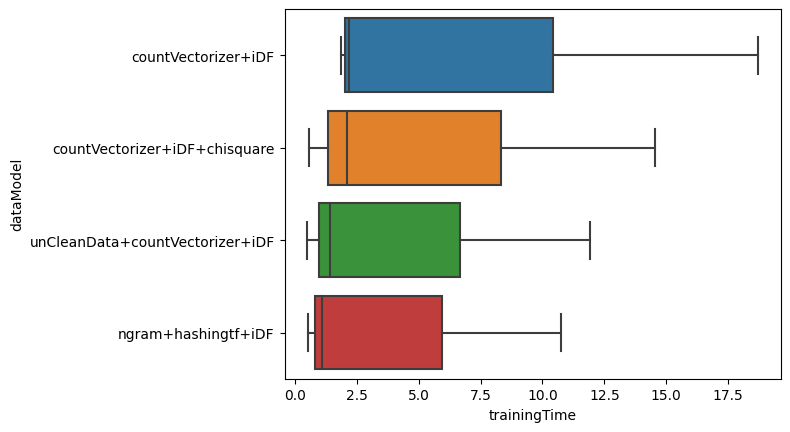

In [38]:

sns.boxplot( x=df["trainingTime"], y=df["dataModel"] )